In [1]:
import os
import random
import sys

from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from seed import seed_everything

%matplotlib inline

In [2]:
seed_everything(137)

# OPTUNA

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Функция-обёртка для Albumentations
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  # Преобразуем PIL.Image в numpy
        augmented = self.transform(image=img)  # Передаём в albumentations
        return augmented["image"]

# Определим преобразования с использованием albumentations
transform_train = AlbumentationsTransform(A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-15, 15), p=0.5),
    # A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=4, min_width=4, fill_value=0, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.RandomGamma(p=0.3),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
]))

transform_test = AlbumentationsTransform(A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
]))


# # Загрузка тренировочного и тестового наборов данных
# trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
# testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

# # Создание DataLoader
# trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
# testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)

/tmp/ipykernel_48154/3548448030.py:20: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=4, min_width=4, fill_value=0, p=0.5),


In [4]:
# images_train, labels_train = trainset.data, trainset.targets

# fig, axes = plt.subplots(3, 5, figsize=(10, 6))
# axes = axes.ravel()

# for i in range(15):
#     image = images_train[i].squeeze()
#     axes[i].imshow(image)
#     axes[i].set_title(f"{labels_train[i]}")
#     axes[i].axis("off")

# plt.tight_layout()
# plt.show();

In [5]:
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
import pytorch_lightning as pl


# Датасет и DataLoader
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = datasets.CIFAR10(
            root="./data", train=True, download=False, transform=transform_train
        )
        self.test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=False, transform=transform_test
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8
        )

In [7]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from torchvision.models import resnet50
import torch.optim as optim
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb


wandb.init()


class OptunaWideResNetLightning(pl.LightningModule):
    def __init__(self, trial, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.trial = trial
        
        # Оптимизируемые гиперпараметры
        self.lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        self.weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
        self.momentum = trial.suggest_float("momentum", 0.8, 0.95)
        
        # Параметры планировщика learning rate
        self.scheduler_factor = trial.suggest_float("scheduler_factor", 0.1, 0.5)
        self.scheduler_patience = trial.suggest_int("scheduler_patience", 2, 10)
        
        # Параметры регуляризации
        self.dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5)
        
        self.model = resnet50(weights=None)
        self.model.fc = nn.Sequential(
            nn.Dropout(self.dropout_prob),
            nn.Linear(2048, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss()
        
        # Добавляем отслеживание лучшей метрики для pruning
        self.best_val_acc = 0.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(dim=1) == targets).float().mean()
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(dim=1) == targets).float().mean()
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}
    
    def on_validation_epoch_end(self):
        # Получаем последнее значение accuracy из логов
        avg_acc = self.trainer.callback_metrics["val_acc"]
        
        # Сообщаем Optuna текущее значение метрики для pruning
        self.trial.report(avg_acc.item(), self.current_epoch)
        
        # Обновляем лучшую точность
        if avg_acc > self.best_val_acc:
            self.best_val_acc = avg_acc
        
        # Проверяем, нужно ли остановить trial
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=self.momentum,
            weight_decay=self.weight_decay
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=self.scheduler_factor,
            patience=self.scheduler_patience,
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }

wandb: Currently logged in as: moscowzhuravlev (moscowzhuravlev-selfemployedalex). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


def objective(trial):
    # Оптимизируемые параметры для DataLoader
    batch_size = trial.suggest_categorical("batch_size", [128])
    
    # Настройка параметров аугментации
    transform_train = AlbumentationsTransform(A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(
            scale=trial.suggest_float("affine_scale", 0.8, 1.2),
            translate_percent=trial.suggest_float("affine_translate", 0.05, 0.15),
            rotate=trial.suggest_int("affine_rotate", -30, 30),
            p=0.5
        ),
        A.CoarseDropout(
            max_holes=1,
            max_height=trial.suggest_int("dropout_max_height", 4, 16),
            max_width=trial.suggest_int("dropout_max_width", 4, 16),
            min_holes=1,
            min_height=2,
            min_width=2,
            fill_value=0,
            p=0.5
        ),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]))
    
    # Настройка данных
    data_module = CIFAR10DataModule(batch_size=batch_size)
    data_module.setup()
    
    # Создание модели с текущими гиперпараметрами
    model = OptunaWideResNetLightning(trial)
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="val_acc",
        dirpath="checkpoints",
        filename=f"trial_{trial.number}",
        save_top_k=1,
        mode="max",
    )
    
    early_stopping = EarlyStopping(
        monitor="val_acc",
        patience=5,
        mode="max",
        min_delta=0.001
    )
    
    # Тренировка
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",
        callbacks=[checkpoint_callback, early_stopping],
        enable_progress_bar=False
    )
    
    try:
        trainer.fit(model, data_module)
    except optuna.exceptions.TrialPruned:
        # Если trial был остановлен, возвращаем текущую лучшую точность
        return model.best_val_acc.item()
    
    return trainer.callback_metrics["val_acc"].item()

# Создание исследования Optuna с MedianPruner
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=5,
        interval_steps=3,
    )
)

# Запуск оптимизации
study.optimize(objective, n_trials=50, timeout=7200)  # 2 часов

# Вывод результатов
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Сохранение результатов в файл
import json
with open('optuna_results.json', 'w') as f:
    json.dump(
        {
            "best_value": trial.value,
            "best_params": trial.params
        },
        f,
        indent=4
    )

[I 2025-02-04 13:34:07,364] A new study created in memory with name: no-name-2fa2e850-9fe9-4321-a5a0-984892402f8e
/tmp/ipykernel_48154/3358107265.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/alex/miniconda3/envs/pytdml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alex/HOMEWORKS/DL/04_CV_w_optuna/checkpoints e

: 

# Попытка №2 (c полученными коэффициентами через optuna)

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Функция-обёртка для Albumentations
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  # Преобразуем PIL.Image в numpy
        augmented = self.transform(image=img)  # Передаём в albumentations
        return augmented["image"]

# Определим преобразования с использованием albumentations
transform_train = AlbumentationsTransform(A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-15, 15), p=0.5),
    # A.Affine(rotate=(-10, 10)),
    # A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    # A.CoarseDropout(max_holes=1, max_height=10, max_width=12, min_holes=1, min_height=4, min_width=4, fill_value=0, p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    # A.HueSaturationValue(p=0.3),
    # A.RandomGamma(p=0.3),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
]))

transform_test = AlbumentationsTransform(A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
]))

In [11]:
BATCH_SIZE = 128
LR = 0.003
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# Датасет и DataLoader
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = datasets.CIFAR10(
            root="./data", train=True, download=False, transform=transform_train
        )
        self.test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=False, transform=transform_test
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8
        )

In [13]:
from torchvision.models import resnet50
import torch.optim as optim
import wandb
from torchmetrics import Accuracy




# Модель WideResNet-28-10
class WideResNetLightning(pl.LightningModule):
    def __init__(self, num_classes=10, lr=LR):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet50(weights=None)
        self.dropout_prob = 0.35
        self.model.fc = nn.Sequential(
            # nn.Dropout(self.dropout_prob),
            nn.Linear(2048, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.lr = lr
        wandb.init()

        # Метрики
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        # Буферы для хранения метрик за эпоху
        self.training_acc_sum = 0.0
        self.training_loss_sum = 0.0
        self.training_batches = 0

        self.validation_acc_sum = 0.0
        self.validation_loss_sum = 0.0
        self.validation_batches = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        acc = self.train_accuracy(outputs, targets)

        # Суммируем значения
        self.training_acc_sum += acc.item()
        self.training_loss_sum += loss.item()
        self.training_batches += 1

        return loss

    def on_train_epoch_end(self):
        # Усредняем accuracy и loss за всю эпоху
        avg_train_acc = self.training_acc_sum / self.training_batches
        avg_train_loss = self.training_loss_sum / self.training_batches

        # Логируем в wandb и Lightning
        wandb.log({"train_loss": avg_train_loss, "train_accuracy": avg_train_acc})
        self.log("train_loss", avg_train_loss, prog_bar=True)
        self.log("train_acc", avg_train_acc, prog_bar=True)

        # Обнуляем счётчики
        self.training_acc_sum = 0.0
        self.training_loss_sum = 0.0
        self.training_batches = 0

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        acc = self.val_accuracy(outputs, targets)

        # Суммируем значения
        self.validation_acc_sum += acc.item()
        self.validation_loss_sum += loss.item()
        self.validation_batches += 1

    def on_validation_epoch_end(self):
        # Усредняем accuracy и loss за всю эпоху
        avg_val_acc = self.validation_acc_sum / self.validation_batches
        avg_val_loss = self.validation_loss_sum / self.validation_batches

        # Логируем в wandb и Lightning
        wandb.log({"val_loss": avg_val_loss, "val_accuracy": avg_val_acc})
        self.log("val_loss", avg_val_loss, prog_bar=True)
        self.log("val_acc", avg_val_acc, prog_bar=True)

        # Обнуляем счётчики
        self.validation_acc_sum = 0.0
        self.validation_loss_sum = 0.0
        self.validation_batches = 0

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return {"optimizer": optimizer, "monitor": "val_loss"}


# Запуск тренировки
data_module = CIFAR10DataModule()
model = WideResNetLightning()

trainer = pl.Trainer(max_epochs=20, accelerator="gpu")
trainer.fit(model, data_module)

wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 23.5 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


train_accuracy,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇█████
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▆▇▇██████████
val_loss,█▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.93303
train_loss,0.65603
val_accuracy,0.74535
val_loss,1.17318


![W&B Chart.png](<attachment:W&B Chart.png>)
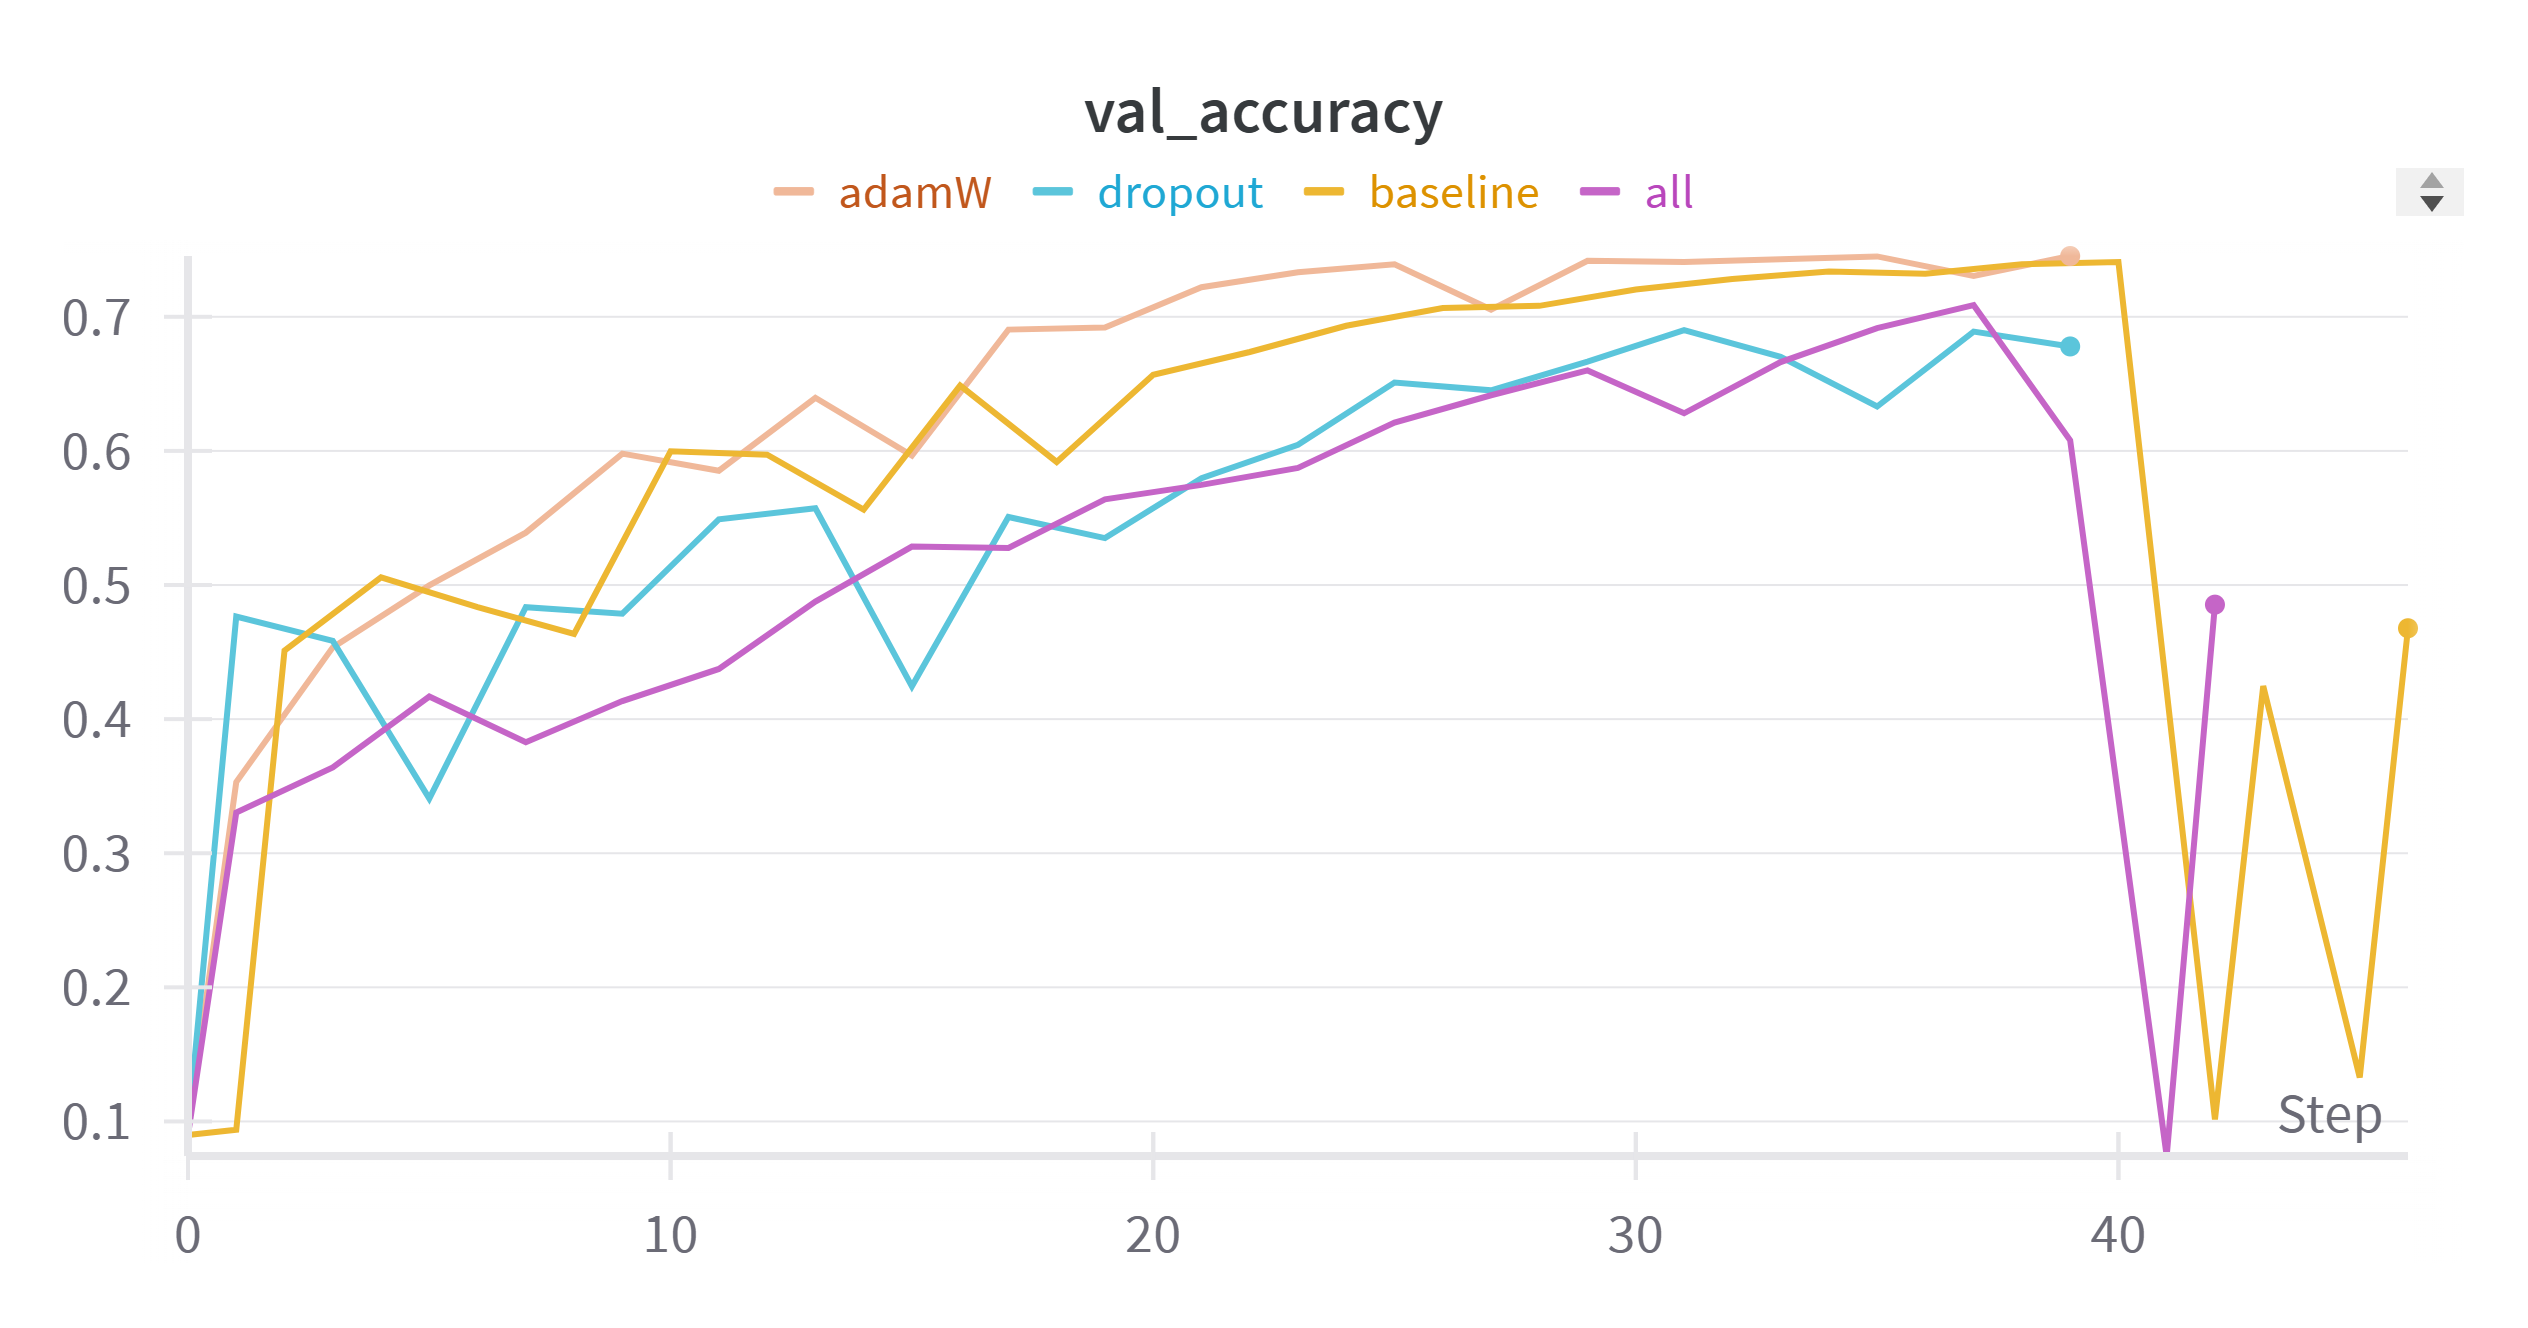